## using pret-raind InceptionV3
---
we can try to "fine-tune" the last convolutional block of the InceptionV3 model alongside the top-level classifier.

In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

input_tensor = Input(shape=(512, 512, 3))

InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
InceptionV3_model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 255, 255, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [2]:
import pandas as pd
data_df = pd.read_csv('../outputs/target_idx.csv')
data_df.head()

,Image Index,Emphysema
0,00000009_000.png,1
1,00000013_041.png,1
2,00000013_042.png,1
3,00000027_000.png,1
4,00000034_000.png,1


In [3]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255., 
                           rotation_range=10,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           zoom_range=0.1,                          
                           validation_split=0.1)

img_dir = "../inputs/images/"

train_generator=datagen.flow_from_dataframe(
                            dataframe=data_df,
                            directory=img_dir,
                            x_col="Image Index",
                            y_col="Emphysema",
                            has_ext=True,                                      
                            subset="training",
                            batch_size=32,
                            seed=1,
                            shuffle=True,
                            color_mode = 'rgb',
                            class_mode="binary",
                            target_size=(512, 512))

valid_generator=datagen.flow_from_dataframe(
                            dataframe=data_df,
                            directory=img_dir,
                            x_col="Image Index",
                            y_col="Emphysema",
                            has_ext=True,                                      
                            subset="validation",
                            batch_size=32,
                            seed=1,
                            shuffle=True,
                            color_mode = 'rgb',
                            class_mode="binary",
                            target_size=(512, 512))

Found 1669 images belonging to 2 classes.
Found 223 images belonging to 2 classes.


In [4]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

In [5]:
top_model = Sequential()
top_model.add(Flatten(input_shape=InceptionV3_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=InceptionV3_model.input, outputs=top_model(InceptionV3_model.output))

In [6]:
for layer in InceptionV3_model.layers:
    layer.trainable = False

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 255, 255, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
STEP_SIZE_TRAIN=100
STEP_SIZE_VALID=20

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=10)

Epoch 1/10
100/100 [==============================] - 3245s 32s/step - loss: 0.7077 - acc: 0.5847 - val_loss: 0.6593 - val_acc: 0.6254
Epoch 2/10
100/100 [==============================] - 3173s 32s/step - loss: 0.6015 - acc: 0.6673 - val_loss: 0.7290 - val_acc: 0.5290
Epoch 3/10
100/100 [==============================] - 3071s 31s/step - loss: 0.6052 - acc: 0.6648 - val_loss: 0.6634 - val_acc: 0.6028
Epoch 4/10
100/100 [==============================] - 2153s 22s/step - loss: 0.5655 - acc: 0.7069 - val_loss: 0.6940 - val_acc: 0.5416
Epoch 5/10
100/100 [==============================] - 1197s 12s/step - loss: 0.5501 - acc: 0.7149 - val_loss: 0.7154 - val_acc: 0.5416
Epoch 6/10
100/100 [==============================] - 914s 9s/step - loss: 0.5518 - acc: 0.7226 - val_loss: 0.6693 - val_acc: 0.5777
Epoch 7/10
100/100 [==============================] - 916s 9s/step - loss: 0.5445 - acc: 0.7247 - val_loss: 0.7288 - val_acc: 0.5369
Epoch 8/10
100/100 [==============================] - 917s 

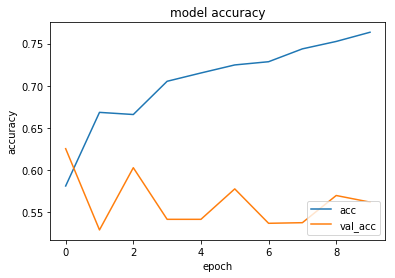

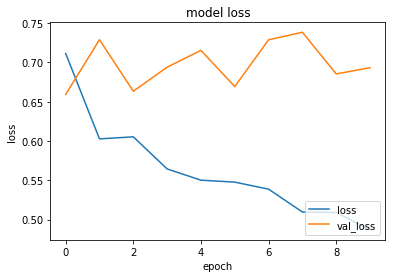

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(history)

In [12]:
import numpy as np
np.savez('../plots/Fine-tuning(InceptionV3)_train', acc=history.history['acc'], loss=history.history['loss'])
np.savez('../plots/Fine-tuning(InceptionV3)_valid', acc=history.history['val_acc'], loss=history.history['val_loss'])